Dr Oliviero Andreussi, olivieroandreuss@boisestate.edu

Boise State University, Department of Chemistry and Biochemistry

# Fitting and Data Analysis for the Kinetics of Methylene Blue RedOx Experiment {-}

## Preliminary Setup {-}

Before we start, let us import the main modules that we will need for this lecture. You may see some new modules in the list below, we will add more details in the right sections.

In [1]:
# @title Notebook Setup { display-mode: "form" }
# Import the main modules used in this worksheet
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
import scipy.optimize
# suppress warnings
import warnings
warnings.filterwarnings('ignore')


# The following needs to be the path of the folder with all your datafile in .csv format
base_path = '/Users/School/PycharmProjects/PChemLab/Kinetics_Data/MB_Data'

In [3]:
# @title Functions to load the data { display-mode: "form" }
def load_data_to_file_dict(file_dict):
    """
    Load a uv-vis .csv file. 
    The format of the file should have two rows of headers and two columns of data (time and absorbance)
    The file may have additional information from the instrument saved at the bottom

    Input variables:
        file_dict : a dictionary with 'path' and 'name' keys corresponding to the file to be loaded
    
    Action: 
        Add to file_dict a Pandas DataFrame with two columns: time (in seconds) and absorbance (in input units)   
    """
    data = pd.read_csv(file_dict['path']+file_dict['name'],header=1,usecols=(0,1)).apply(pd.to_numeric,errors='coerce').dropna()
    data = data[data['Abs']>0.]
    if data.keys()[0] == 'Time (sec)' :
        data = data.rename(columns={'Time (sec)':'time'})
    elif data.keys()[0] == 'Time (min)' :
        data['time'] = data['Time (min)'] * 60
        data = data.drop('Time (min)',axis=1)
    data = data.rename(columns={'Abs':'absorbance'})
    file_dict['data'] = data
    return

def load_data_to_file_list(file_list):
    """
    Given a list of dictionary files, recursively use load_data_to_file_dict to load the data into each of the dictionaries

    Input variables:
        file_list : a list of dictionary files, each with 'path' and 'name' keys corresponding to the file to be loaded
    
    Action: 
        Add to each file_dict a Pandas DataFrame with two columns: time (in seconds) and temperature (in input units)   
    """
    for f in file_list : 
        if not ('data' in f): load_data_to_file_dict(f)
    return

def plot_file_dict(file_dict, semilog=False, with_fit=False):
    """
    Given a dictionary file of a bomb calorimetry experiment, plot temperature vs. time.

    Input variables:
        file_dict : a dictionary file with 'path' and 'name' keys corresponding to the file to be loaded
        semilog : use a logarithmic scale for the absorbance axis
        with_fit : plot the fitted curve, if present
    
    Action: 
        Plot absorbance vs. time for the selected file 
    """
    fig, ax = plt.subplots()
    if not ('data' in file_dict): 
        load_data_to_file_dict(f)
    if semilog :
        plt.semilogy(file_dict['data']['time'],file_dict['data']['absorbance'],label=file_dict['label'])
        if with_fit and 'absorbance_fitted' in file_dict['data'].keys(): 
            plt.semilogy(file_dict['data']['time'],file_dict['data']['absorbance_fitted'],':',label=file_dict['label']+' fit')
    else:
        plt.plot(file_dict['data']['time'],file_dict['data']['absorbance'],label=file_dict['label'])
        if with_fit and 'absorbance_fitted' in file_dict['data'].keys(): 
            plt.plot(file_dict['data']['time'],file_dict['data']['absorbance_fitted'],':',label=file_dict['label']+' fit')
    plt.xlabel('Time (s)')
    plt.ylabel('Absorbance (a.u.)')
    plt.legend()
    plt.show()

def plot_file_list(file_list,key='',value=[''],semilog=False,with_fit=False):
    """
    Given a list of dictionary files, plot absorbance vs. time for each file into the same plot.
    If key/value are specified, only plot the files for which the key has the specified value.

    Input variables:
        file_list : a list of dictionary files, each with 'path' and 'name' keys corresponding to the file to be loaded
        key: a string with the name of the key to shortlist the files
        value: the value of the key used to select the shortlist of files
    
    Action: 
        Plot absorbance vs. time for the selected files  
    """
    if value == '' or key == '':
        file_shortlist = file_list
    else :
        file_shortlist = [f for f in file_list if f[key] in value ]
    fig, ax = plt.subplots()
    for i,f in enumerate(file_shortlist) : 
        color='C'+str(i)
        if not ('data' in f): 
            load_data_to_file_dict(f)
        if semilog :
            plt.semilogy(f['data']['time'],f['data']['absorbance'],color=color,label=f['label'])
            if with_fit and 'absorbance_fitted' in f['data'].keys(): 
                plt.semilogy(f['data']['time'],f['data']['absorbance_fitted'],':',color=color,label=f['label']+' fit')
        else:
            plt.plot(f['data']['time'],f['data']['absorbance'],color=color,label=f['label'])
            if with_fit and 'absorbance_fitted' in f['data'].keys(): 
                plt.plot(f['data']['time'],f['data']['absorbance_fitted'],':',color=color,label=f['label']+' fit')
    plt.xlabel('Time (s)')
    plt.ylabel('Absorbance (a.u.)')
    plt.legend()
    plt.show()

In [4]:
# @title Functions to fit the data { display-mode: "form" }
def linear(t, a, k, o):
    """ 
    Function that returns a linear decaying function that saturates to an offset
    f(t) = o + a - k * t (for t < a/k) or o (for t > a/k)

    input variables
    t: input value (units of time)
    a: amplitude (units of absorbance or concentration)
    k: decay rate (units of 1/time)
    o: offset (units of absorbance or concentration)
    """
    filter = t < a/k
    return o + filter * (a - k * t)

def exponential(t, a, k, o):
    """ 
    Function that returns an exponentially decaying function plus offset
    f(t) = o + a*e^(-k*t)

    input variables
    t: input value (units of time)
    a: amplitude (units of absorbance or concentration)
    k: decay rate (units of 1/time)
    o: offset (units of absorbance or concentration)
    """
    return a * np.exp(-k*t) + o

def inverse(t, a, k, o):
    """ 
    Function that returns a inverse decaying function plus offset
    f(t) = o + 1/(1/a + 2*k*t) 

    input variables
    t: input value (units of time)
    a: amplitude (units of absorbance or concentration)
    k: decay rate (units of 1/time)
    o: offset (units of absorbance or concentration)
    """
    return o + 1/(1/a+2*k*t)

# Functions designed for fit the kinetics data
def fit_kinetic(file_dict):
    """ 
    Perform the fit of kinetic decay curves (uv-vis absorption spectra) using non-linear
    functions plus offset. 

    Input parameters: 
    file_dict: a dictionary with information on the file with the data (path and name) and
               adjustable parameters related to the fit:
               time_skip : initial transient regime to remove from the fit
               order: order of the kinetics to fit (zeroth, first, or second)
               MB0_guess, k_guess, offset_guess: starting guess of fitting parameters

    Action: 
           Filter the data by removing the initial time_skip part of the curve
           Fit one of three non-linear regimes according to the specified order (linear, exponential, inverse)
           Save the optimized values of the parameters and their standard errors in file_dict
           Save the fitted curve in the file_dict['data'] DataFrame
    """   
    if not ('data' in file_dict): 
        load_data_to_file_dict(file_dict)
        
    filtered_data = file_dict['data'][file_dict['data']['time']>file_dict['time_skip']]
    x = filtered_data['time']
    y = filtered_data['absorbance']

    if file_dict['order'] == 'zeroth' :
        funct = linear
    elif file_dict['order'] == 'first' :
        funct = exponential
    elif file_dict['order'] == 'second' :
        funct = inverse

    p0 = (file_dict['MB0_guess'],file_dict['k_guess'],file_dict['offset_guess'])
    params, cv = scipy.optimize.curve_fit(funct,x,y,p0)

    file_dict['MB0'] = params[0]
    file_dict['MB0_SE'] = np.sqrt(cv[0,0])
    file_dict['k'] = params[1]
    file_dict['k_SE'] = np.sqrt(cv[1,1])
    file_dict['offset'] = params[2] 
    file_dict['offset_SE'] = np.sqrt(cv[2,2])

    file_dict['data']['absorbance_fitted'] = funct(file_dict['data']['time'],params[0],params[1],params[2])

## Visualize the Systems {-}

The following module needs to be installed on Colab. We won't need it too much for this analysis, but they offer a lot of nice features for chemistry programming. 

In [5]:
# @title Install and load RDKit { display-mode: "form" }
!pip install rdkit
from rdkit import Chem
from rdkit.Chem import Draw
!pip install cirpy
import cirpy

In particular we can use them to draw the molecules in our experiments. While for some molecules you can just write their names and RDKit will plot them, for most molecules you will need to provide their SMILES or their CAS numbers. Luckily, CIRpy can usually find SMILES for you, if you type the common name correctly or if you know the CAS number. 

These are the SMILES for the molecules in your kinetics experiments:
* Methylene Blue: '[Cl-].CN(C)c1ccc2nc3ccc(cc3[s+]c2c1)N(C)C'
* Leucomethylene Blue: 'CN(C)c1ccc2Nc3ccc(cc3Sc2c1)N(C)C'
* Ascrobic Acid: 'OCC(O)C1OC(=C(O)C1=O)O'
* Ascorbate: 'OC[C@H](O)[C@H]1OC(=O)[C-](O)C1=O'

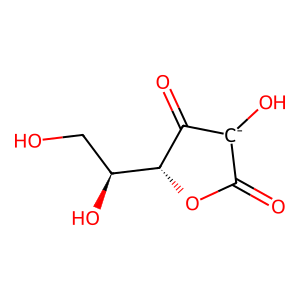

In [6]:
# @title Choose the molecule to draw { display-mode: "form" }
input = 'ascorbate' # @param {type:"string"}
input_type = 'name' # @param ["smiles", "name", "cas"] {allow-input: true}
if input_type != 'smiles' :
    smiles=cirpy.resolve( input, 'smiles')
else:
    smiles=input
img = Draw.MolToImage( Chem.MolFromSmiles(smiles), size=(300, 300) )
display(img)

## Loading the Data {-}

We need to load the Google Drive and access an example of a dataset from a kinetics experiment. You can use the same set that I am using by downloading it from Canvas, [here](). Or you can use your own files. I am assuming the file in question will be located in a `Kinetics_Data/` subfolder in your `Colab Notebook/` folder. 

In [20]:
# @title Set Local Path { display-mode: "form" }
# The following needs to be the path of the folder with all your collected data in .csv format
local_path="/Users/School/PycharmProjects/PChemLab/Kinetics_Data/MB_Data" # @param {type:"string"}
path = "/Users/School/PycharmProjects/PChemLab/Kinetics_Data/MB_Data/"

In order to streamline the fitting of the data, we will be storing the file that corresponds to each experiment into a Python dictionary (`dict`), together with all the relevant information of that experiment and the parameters that we need for the fit. You can use the same statement in the following, but make sure to change the file name from 'SetArun1.csv' (the one that I am using) to the one you want to use.

In [21]:
file1 = {'path':path, 'name':'SetA_T1revise.csv', 'label':'Run1', 'set':'A', '[MB]': 0.1, '[AA]': 0.1, '[HCl]': 0.1, 'pH': 1, 'order': 'first', 'MB0_guess': 1., 'k_guess': 1., 'offset_guess': 0.1 }

In [22]:
load_data_to_file_dict(file1)

We should always check that the loaded data looks ok, say by checking the number of columns and rows and, maybe, plotting the two columns

In [23]:
file1['data'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 2715 entries, 0 to 2714
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   absorbance  2715 non-null   float64
 1   time        2715 non-null   float64
dtypes: float64(2)
memory usage: 63.6 KB


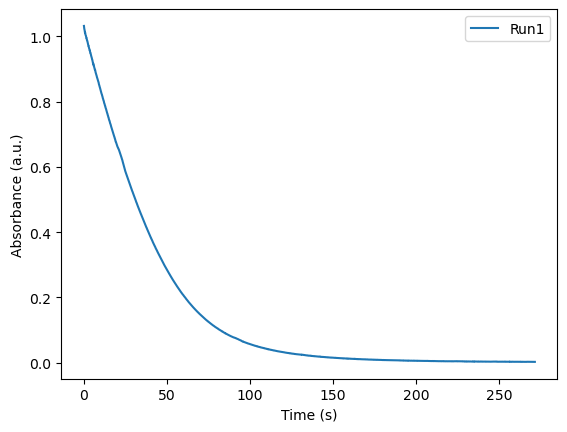

In [24]:
plot_file_dict(file1)

We can also plot the same data using a semilog plot (with the y-axis in log scale)

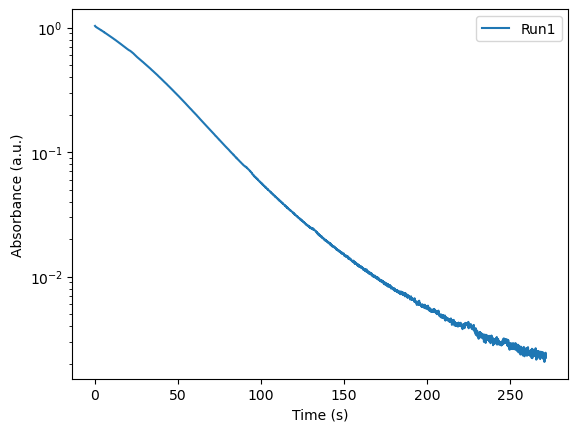

In [25]:
plot_file_dict(file1,semilog=True)

## Trying to Fit with Simple Linear Regression {-}

It would be nice if we could just use the linear regression algorithm that we have used before to fit the kinetics curves. However, one of our tasks requires to identify the order of the reaction with respect to the concentration of methylene blue (abbreviated in $[MB]$ in the following). Different orders of kinetics correspond to different decay curves. 
* A reaction that is of zeroth order will have a linear decay in $[MB]$, i.e. $[MB](t)=[MB0]-kt$
* A reaction that is of first order will have an exponential decay in $[MB]$, i.e. $[MB](t)=[MB0]e^{-kt}$
* A reaction that is of second order will have a decay inversile proportional to $[MB]$, i.e. $[MB](t)=\frac{1}{1/[MB0]+kt}$


In principles, if we make the appropriate change of variables, we can linearize all three of the above equations and try to use linear regression to perform the fit of the data.

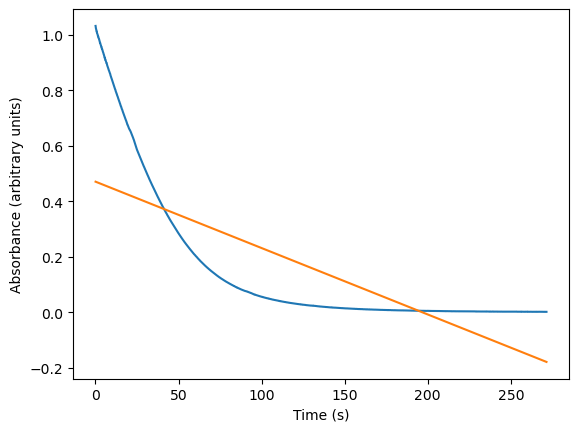

In [26]:
zeroth_order=LinearRegression()
x=file1['data']['time'].values.reshape(-1,1)
y=file1['data']['absorbance'].values
zeroth_order.fit(x,y)
plt.plot(x,y)
plt.plot(x,zeroth_order.predict(x))
plt.xlabel('Time (s)')
plt.ylabel('Absorbance (arbitrary units)')
plt.show()

Can you try to fit the same data using a first order or a second order model? You will need to change the definition of the dependent variable to make the linear fit appropriate. For the first order you want to fit $log([MB])$ while for the second order model you want to fit $1/[MB]$. 

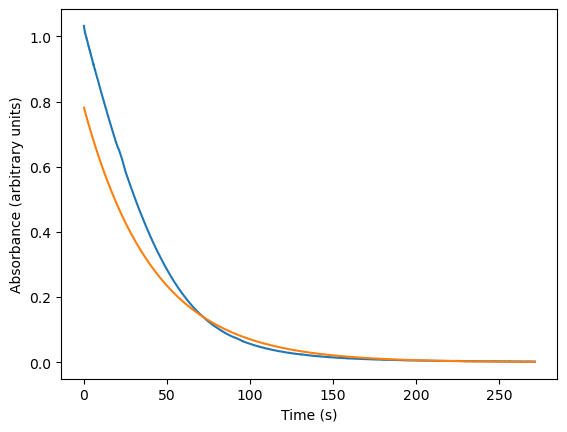

In [27]:
first_order=LinearRegression()
x=file1['data']['time'].values.reshape(-1,1)
y=np.log(file1['data']['absorbance'].values)
first_order.fit(x,y)
plt.plot(x,np.exp(y))
plt.plot(x,np.exp(first_order.predict(x)))
#plt.semilogy(x,np.exp(y))
#plt.semilogy(x,np.exp(first_order.predict(x)))
plt.xlabel('Time (s)')
plt.ylabel('Absorbance (arbitrary units)')
plt.show()

Which of the models works the best? Is any of the model giving a decent fit of the data? Why or why not? Is the linearization trick always appropriate? 

## Alternative Fit using Scipy {-} 

One of the possible causes of poor fitting is the fact that our experimental results do not go to zero exactly, but they converge to a baseline, i.e. there is an offset in the data. Unfortunately the offset is tricky to remove and it makes the linearization trick fail. However, we can still try to fit using a non-linear model. The algorithm that optimize an arbitrary model, even those that are non-linear in the parameters, are a bit more tricky to use. They are not able to get the optimal solution directly, but rather they need to optimize the solution one step at the time. The starting point of the algorithm is usually important to ensure convergence and that we get to the best set of parameters. 

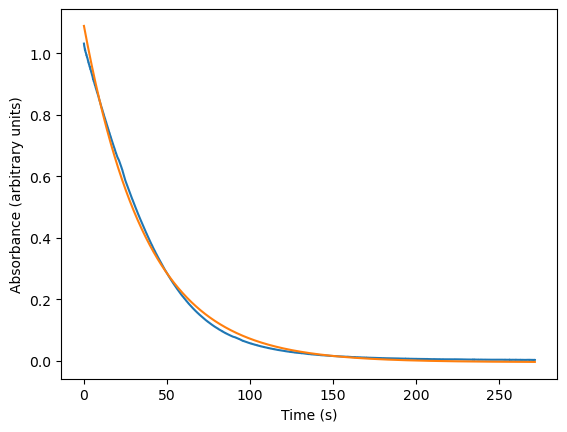

The optimized values of the parameters are: 
MB0 = 1.0963, k = 0.0266, offset = -0.0051
The standard errors on these parameters are: 
SE_MBO = 0.0014, SE_k = 0.0001, SE_offset = 0.0004
The R2 of the fit on the used data is   0.9972


In [28]:
# @title Try alternative non-linear fits { display-mode: "form" }
order = 'first' # @param ['zeroth', 'first', 'second'] {allow-input: true}
semilog = False # @param {type:"boolean"}
time_skip = 0 # @param {type:"number"}

MB0 = 0.5 # @param {type:"number"}
k = 0.1 # @param {type:"number"}
offset = 0.05 # @param {type:"number"}
p0 = (MB0, k, offset) # this are the starting values of the parameters of the function

if order == 'zeroth' :
    funct = linear
elif order == 'first' :
    funct = exponential
elif order == 'second' : 
    funct = inverse

# filter and fit the data
filtered_data = file1['data'][file1['data']['time']>time_skip]
x = filtered_data['time']
y = filtered_data['absorbance']
params, cv = scipy.optimize.curve_fit(funct,x,y,p0)

# plot the data together with the fit
if semilog : 
    plt.semilogy(file1['data']['time'],file1['data']['absorbance'])
    plt.semilogy(file1['data']['time'],funct(file1['data']['time'],params[0],params[1],params[2]))
else:
    plt.plot(file1['data']['time'],file1['data']['absorbance'])
    plt.plot(file1['data']['time'],funct(file1['data']['time'],params[0],params[1],params[2]))
plt.xlabel('Time (s)')
plt.ylabel('Absorbance (arbitrary units)')
plt.show()

# compute correlation coefficient
RSS = np.sum((y-funct(x,params[0],params[1],params[2]))**2)
TSS = np.sum((y-y.mean())**2)
R2 = 1-RSS/TSS

# print results
print(f"The optimized values of the parameters are: \nMB0 = {params[0]:6.4f}, k = {params[1]:6.4f}, offset = {params[2]:6.4f}")
print(f"The standard errors on these parameters are: \nSE_MBO = {np.sqrt(cv[0,0]):6.4f}, SE_k = {np.sqrt(cv[1,1]):6.4f}, SE_offset = {np.sqrt(cv[2,2]):6.4f}")
print(f"The R2 of the fit on the used data is {R2:8.4f}")

The fit returns two objects, which we labeled `params` and `cv`:
* the first one contains the value of the optimal parameters, those that give the smallest deviation from the experimental curve
* the second object contains the covariance matrix of the parameters: the diagonal of this matrix has the variance in the estimate of the parameter, which you can use as an error estimate for your parameter

## Check Each of Your Experiments

Repeat the analysis above for each one of your curves. Make sure to take note of the important parameters that affect your analysis the most (e.g. `time_skip` and the starting values of the fitting parameters), you will need them in your worksheet. 

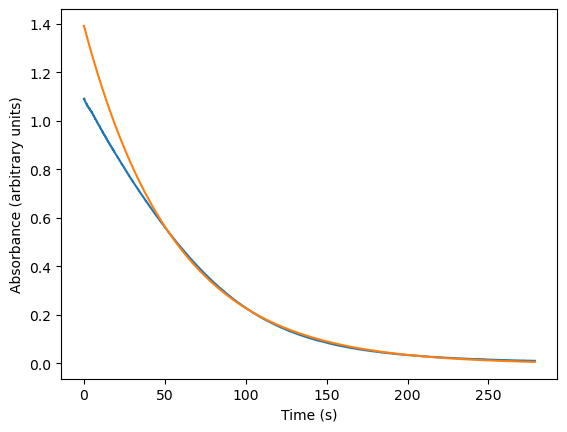

The optimized values of the parameters are: 
MB0 = 1.3956, k = 0.0180, offset = -0.0031
The standard errors on these parameters are: 
SE_MBO = 0.0020, SE_k = 0.0000, SE_offset = 0.0002
The R2 of the fit on the used data is   0.9991


In [30]:
# @title Check the parameters on each of your files { display-mode: "form" }
name = 'SetB_T3.csv' # @param {type:"string"}
order = 'first' # @param ['zeroth', 'first', 'second'] {allow-input: true}
semilog = False # @param {type:"boolean"}
time_skip = 40 # @param {type:"number"}

MB0 = 0.5 # @param {type:"number"}
k = 0.1 # @param {type:"number"}
offset = 0.05 # @param {type:"number"}
p0 = (MB0, k, offset) # this are the starting values of the parameters of the function

newfile = {'path':path, 'name':name, 'set':'', '[MB]': 1, '[AA]': 1, '[HCl]': 1, 'pH': 1, 'order': order, 'MB0_guess': MB0, 'k_guess': k, 'offset_guess': offset }
load_data_to_file_dict(newfile)

if order == 'zeroth' :
    funct = linear
elif order == 'first' :
    funct = exponential
elif order == 'second' : 
    funct = inverse

# filter and fit the data
filtered_data = newfile['data'][newfile['data']['time']>time_skip]
x = filtered_data['time']
y = filtered_data['absorbance']
params, cv = scipy.optimize.curve_fit(funct,x,y,p0)

# plot the data together with the fit
if semilog : 
    plt.semilogy(newfile['data']['time'],newfile['data']['absorbance'])
    plt.semilogy(newfile['data']['time'],funct(newfile['data']['time'],params[0],params[1],params[2]))
else:
    plt.plot(newfile['data']['time'],newfile['data']['absorbance'])
    plt.plot(newfile['data']['time'],funct(newfile['data']['time'],params[0],params[1],params[2]))
plt.xlabel('Time (s)')
plt.ylabel('Absorbance (arbitrary units)')
plt.show()

# compute correlation coefficient
RSS = np.sum((y-funct(x,params[0],params[1],params[2]))**2)
TSS = np.sum((y-y.mean())**2)
R2 = 1-RSS/TSS

# print results
print(f"The optimized values of the parameters are: \nMB0 = {params[0]:6.4f}, k = {params[1]:6.4f}, offset = {params[2]:6.4f}")
print(f"The standard errors on these parameters are: \nSE_MBO = {np.sqrt(cv[0,0]):6.4f}, SE_k = {np.sqrt(cv[1,1]):6.4f}, SE_offset = {np.sqrt(cv[2,2]):6.4f}")
print(f"The R2 of the fit on the used data is {R2:8.4f}")